# TIKPIT explainable evaluation

In [1]:
!pip install pywikibot
!wget -nc -q <DOWNLOAD_user-config.py>
!wget -nc -q <DOWNLOAD_user-password.py>
!python -m spacy download en_core_web_lg

import re
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import pywikibot
import spacy

tqdm.pandas()

In [ ]:
# Load resources
nltk.download("stopwords")
nlp = spacy.load('en_core_web_lg')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Structural accuracy scores

In [ ]:
def structural_accuracy(sample):
  parts = sample.split("<|summary|>")
  keywords = re.sub(r"(<\|[^\|]+\|>)|( nan )", "", parts[0])
  keywords = re.sub(r"\(|\)|-|,", " ", keywords)
  keywords = re.sub(r"(\s{2,})", " ", keywords)
  keywords = re.sub(r"(^\s+)|(\s+$)", "", keywords).lower().split(" ")
  keywords = [keyword for keyword in keywords if keyword not in stopwords.words('english')]
  generated = parts[1].lower()
  matches = [keyword for keyword in keywords if keyword in generated]

  return len(matches)/len(keywords)

# TIKPIT implementation

In [ ]:
df_generate = pd.read_csv("data/dataset_no_en_full.csv").drop("summary", axis=1)

# If person has no item description (Q[0-9]+), use fname and lname to fix it whenever possible
df_generate.loc[df_generate.itemLabel.str.startswith("Q"), "itemLabel"] = df_generate.loc[df_generate.itemLabel.str.startswith("Q"), "fnames"].astype(str).str.replace("^nan$","")+" "+df_generate.loc[df_generate.itemLabel.str.startswith("Q"), "lnames"].astype(str).str.replace("^nan$", "")
df_generate.itemLabel = df_generate.itemLabel.str.replace("(^\s+)|(\s+$)", "")
df_generate = df_generate[df_generate.itemLabel!=""]
df_generate

,item,itemLabel,fnames,lnames,itemDescription,birth,death,professions
0,Q18945651,Marsilio Cagnati,NaN,NaN,1543-1612,1543,1612,physician
1,Q55901911,Angelo Gualandris,Angelo,NaN,botanist (1750-1788),1750,1788,"naturalist, geologist, agronomist, botanist"
2,Q1522146,Giacomo Nani,Giacomo,Nani,politician (1725-1797),1725,1797,politician
3,Q21656610,Joannes Bernardus Felicianus,Giovanni,NaN,NaN,1490,1552,physician
4,Q19838679,Ermolao Donà,Ermolao,NaN,NaN,NaN,1450,"politician, diplomat"
...,...,...,...,...,...,...,...,...
1615,Q16531271,Bartolomeo Orioli,Bartolomeo,NaN,Italian painter (1568-1627),1568,1627,painter
1616,Q22916128,Paolo Calvi,Paolo,Calvi,Italian biographer (1716-1781),1716,1781,biographer
1618,Q3852178,Matteo Polo,"Maffeo, Matteo",Polo,Italian merchant (1252-1309),1252,1309,merchant
1619,Q3903724,Pietro Buratti,Pietro,Buratti,Italian poet,1773,1832,poet


In [ ]:
site = pywikibot.Site()
site.login()

def gather_text(row):
  page = pywikibot.Page(site, row.itemLabel)
  return re.sub("\[\[wikipedia:[^\|]+\|", "", page.text.split("}}\n")[-1].replace("]]", ""))

df_generate["summary"] = df_generate.progress_apply(gather_text, axis=1)

In [ ]:
df_generate.to_csv("dataset_no_en_generated.csv")

In [ ]:
df_training = pd.read_csv("data/dataset_en_full.csv")

# If person has no item description (Q[0-9]+), use fname and lname to fix it whenever possible
df_training.loc[df_training.itemLabel.str.startswith("Q"), "itemLabel"] = df_training.loc[df_training.itemLabel.str.startswith("Q"), "fnames"].astype(str).str.replace("^nan$","")+" "+df_training.loc[df_training.itemLabel.str.startswith("Q"), "lnames"].astype(str).str.replace("^nan$", "")
df_training.itemLabel = df_training.itemLabel.str.replace("(^\s+)|(\s+$)", "")
df_training = df_training[df_training.itemLabel!=""]
df_training

,item,itemLabel,fnames,lnames,itemDescription,birth,death,professions,summary
0,Q1918086,"Meinhard I, Count of Gorizia",Meinhard,NaN,"Count of Gorizia, Count Palatine in Carinthia",1070,1142,aristocrat,"Meinhard I (c. 1070 – 1142), an ancestor of th..."
1,Q723300,Pietro Gradenigo,Pietro,Gradenigo,doge of Venice,1251,1311,politician,Pietro Gradenigo (1251 – 13 August 1311) was t...
2,Q3903778,Pietro Cesare Alberti,Pietro,Alberti,Immigrant,1608,1655,sailor,Pietro Cesare Alberti (1608–1655) — later Pete...
3,Q935405,Francis II of Naxos,Francesco,NaN,Duke of the Archipilago (Naxos),1417,1463,NaN,Francesco II Crispo (died 1463) was the sixtee...
4,Q3513653,Rajmundo Kunić,"Rajmund, Raimondo",NaN,Croatian writer,1719,1794,poet,"Raimondo Cunich or Rajmundo Kunić (January 17,..."
...,...,...,...,...,...,...,...,...,...
1657,Q2471553,Ago of Friuli,NaN,NaN,Duke of Friuli,0650,0662,aristocrat,Ago was the Duke of Friuli from between 651 an...
1658,Q1528422,Giuseppe Maria Foppa,Giuseppe,NaN,Italian librettist,1760,1845,"writer, translator, librettist","Giuseppe Maria Foppa (Venice, 12 July 1760 – V..."
1659,Q3767219,Giovanni Ferrari,Giovanni,Ferrari,Italian artist (1744-1826),1744,1826,sculptor,"Giovanni Ferrari detto Torretto (5 June 1744, ..."
1660,Q1855242,Alessandro Longhi,Alessandro,Longhi,Italian painter and engraver (1733-1813),1733,1813,"painter, printmaker, copperplate engraver",Alessandro Longhi (12 June 1733 – November 181...


In [ ]:
import itertools
import operator
from collections import Counter

df_training_professions = df_training[df_training.professions.notna()]

professions = list(itertools.chain.from_iterable(df_training_professions.professions.str.split(", ").values))
prof_dict = Counter(professions)

sorted_prof = sorted(prof_dict.items(), key=operator.itemgetter(1), reverse=True)
print(len(sorted_prof))
selected_prof = [prof[0] for prof in sorted_prof[:100]]
selected_prof

261


['painter',
 'writer',
 'Catholic priest',
 'composer',
 'politician',
 'diplomat',
 'poet',
 'architect',
 'sculptor',
 'historian',
 'philosopher',
 'military personnel',
 'translator',
 'mathematician',
 'aristocrat',
 'priest',
 'engraver',
 'librettist',
 'physician',
 'organist',
 'printmaker',
 'linguist',
 'playwright',
 'librarian',
 'opera singer',
 'university teacher',
 'singer',
 'music theorist',
 'astronomer',
 'anatomist',
 'physicist',
 'engineer',
 'artist',
 'explorer',
 'musicologist',
 'typographer',
 'cartographer',
 'drawer',
 'actor',
 'publisher',
 'condottiero',
 'catholic deacon',
 'theologian',
 'salonnière',
 'geographer',
 'editor',
 'art historian',
 'scientist',
 'etcher',
 'musician',
 'association football player',
 'illuminator',
 'stage actor',
 'novelist',
 'religious',
 'violinist',
 'cleric',
 'printer',
 'rabbi',
 'lutenist',
 'author',
 'archaeologist',
 'inventor',
 'classical scholar',
 'copperplate engraver',
 'patron of the arts',
 'art coll

In [ ]:
def extract_lifecentury(row):
  life_dates = []
  if str(row.birth).isnumeric():
    life_dates.append(int(row.birth))
  if str(row.death).isnumeric():
    life_dates.append(int(row.death))
  if len(life_dates) == 0:
    return 0
  return int(np.mean(life_dates)//100)

df_training_professions["century"] = df_training_professions.apply(extract_lifecentury, axis=1)

df_generate_professions = df_generate[df_generate.professions.notna()]
df_generate_professions["century"] = df_generate_professions.apply(extract_lifecentury, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
kpit_text_training = {}
kpit_text_generate = {}

for prof in selected_prof:
  for century in range(14,19):
    kpit_text_training[(prof, century)] = ' '.join(df_training_professions[(df_training_professions.professions.str.contains(prof)) & (df_training_professions.century == century)].summary)
    kpit_text_generate[(prof, century)] = ' '.join(df_generate_professions[(df_generate_professions.professions.str.contains(prof)) & (df_generate_professions.century == century)].summary)

In [ ]:
#NEVER TRY TO PRINT IT ON SCREEN!
#len(kpit[("painter", 18)])
len(kpit_text.values())

500

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import TfidfVectorizer
import string

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    nlp.max_length=2000000
    mytokens = nlp(sentence, disable=["ner"])

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations and word.isalpha() and word not in ["venice", "venetian"]+selected_prof]

    # return preprocessed list of tokens
    return mytokens

In [ ]:
vectorizer_training = TfidfVectorizer(tokenizer=spacy_tokenizer)
tikpit_training = vectorizer_training.fit_transform(tqdm(kpit_text_training.values()))

vectorizer_generate = TfidfVectorizer(tokenizer=spacy_tokenizer)
tikpit_generate = vectorizer_generate.fit_transform(tqdm(kpit_text_generate.values()))

In [ ]:
n = 30

feature_array_training = np.array(vectorizer_training.get_feature_names())
top_tikpit_training = []
for vector in tikpit_training.toarray():
  tfidf_sorting = np.argsort(vector).flatten()[::-1]
  top_tikpit_training.append(feature_array_training[tfidf_sorting][:n])

feature_array_generate = np.array(vectorizer_generate.get_feature_names())
top_tikpit_generate = []
for vector in tikpit_generate.toarray():
  tfidf_sorting = np.argsort(vector).flatten()[::-1]
  top_tikpit_generate.append(feature_array_generate[tfidf_sorting][:n])

In [ ]:
top_tikpit_assoc_training = []
top_tikpit_assoc_generate = []

iter = 0
for prof in selected_prof:
  for century in range(14,19):
    top_tikpit_assoc_training.append([prof, century, top_tikpit_training[iter]])
    top_tikpit_assoc_generate.append([prof, century, top_tikpit_generate[iter]])
    iter+=1

top_tikpit_df_training = pd.DataFrame(top_tikpit_assoc_training, columns=["profession", "century", "toptikpit"])
top_tikpit_df_generate = pd.DataFrame(top_tikpit_assoc_generate, columns=["profession", "century", "toptikpit"])

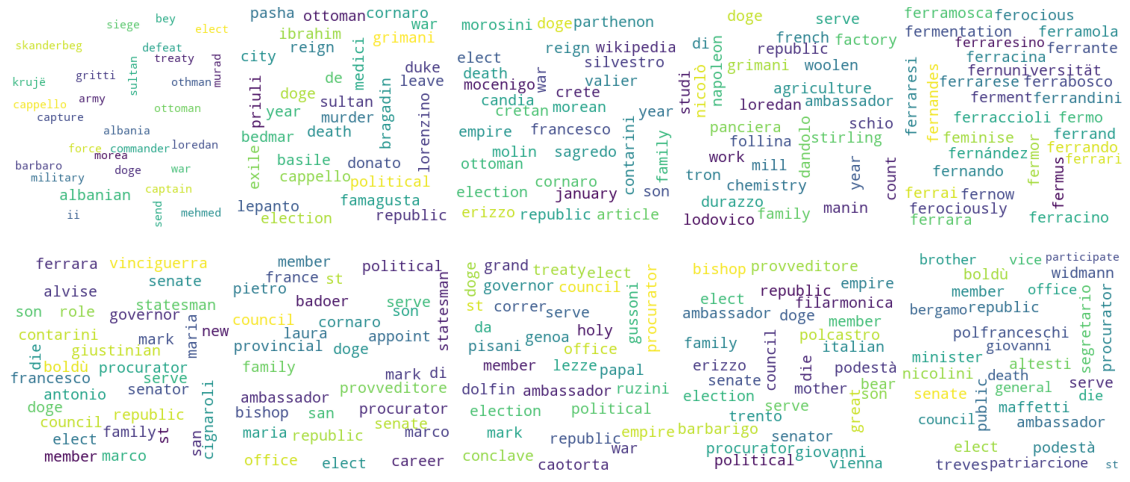

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(20,9))
for i in range(0, 5):
  wordcloud = WordCloud(width = 300, height = 300, background_color="white", collocations=False, max_font_size=20).generate(' '.join(top_tikpit_df_training[top_tikpit_df_training.profession=="politician"].toptikpit.values[i]))
  axes[0,i].imshow(wordcloud)
  axes[0,i].axis('off')

  wordcloud = WordCloud(width = 300, height = 300, background_color="white", collocations=False, max_font_size=20).generate(' '.join(top_tikpit_df_generate[top_tikpit_df_generate.profession=="politician"].toptikpit.values[i]))
  axes[1,i].imshow(wordcloud)
  axes[1,i].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("top-tikpit.png", dpi=600)

In [ ]:
top_tikpit_df.profession.unique()
#top_tikpit_df[top_tikpit_df.profession=="military officer"]

array(['painter', 'writer', 'Catholic priest', 'composer', 'politician',
       'diplomat', 'poet', 'architect', 'sculptor', 'historian',
       'philosopher', 'military personnel', 'translator', 'mathematician',
       'aristocrat', 'priest', 'engraver', 'librettist', 'physician',
       'organist', 'printmaker', 'linguist', 'playwright', 'librarian',
       'opera singer', 'university teacher', 'singer', 'music theorist',
       'astronomer', 'anatomist', 'physicist', 'engineer', 'artist',
       'explorer', 'musicologist', 'typographer', 'cartographer',
       'drawer', 'actor', 'publisher', 'condottiero', 'catholic deacon',
       'theologian', 'salonnière', 'geographer', 'editor',
       'art historian', 'scientist', 'etcher', 'musician',
       'association football player', 'illuminator', 'stage actor',
       'novelist', 'religious', 'violinist', 'cleric', 'printer', 'rabbi',
       'lutenist', 'author', 'archaeologist', 'inventor',
       'classical scholar', 'copperplate engr